<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="./images/DLI_Header.png"></a></div>

# Introduction to `NVIDIA Merlin dataloaders`

Before we begin building our neural networks, our [Amazon dataset](https://nijianmo.github.io/amazon/index.html) has changed slightly from the first lab. To read it into TensorFlow efficiently, we'll take advantage of a framework called [NVIDIA Merlin](https://developer.nvidia.com/nvidia-merlin).<br><br>

NVIDIA Merlin is a open source framework to accelerate recommendation systems end-to-end with GPUs: From ETL to training to deployment. Merlin has different components for each step. In this tutorial, we use [NVTabular](https://github.com/NVIDIA/NVTabular/)'s dataloader for TensorFlow, called `KerasSequenceLoader`. The dataloader can be the bottleneck of a training pipeline, which results into slow training. Recommender System problems often have a tabular data structure, so NVIDIA developed a custom-built, GPU-accelerated dataloader, which reads and prepares batches of data on the GPU.

You can read more in the official [documentation](https://nvidia-merlin.github.io/NVTabular/main/training/index.html) or in this [blog post](https://medium.com/nvidia-merlin/training-deep-learning-based-recommender-systems-9x-faster-with-tensorflow-cc5a2572ea49).

## Objective
This notebook demonstrates:
* How to use a [NVTabular dataloader](https://nvidia-merlin.github.io/NVTabular/main/training/tensorflow.html)
  * [1. Exploring the Data](#1.-Exploring-the-Data)
  * [2. Using a NVTabular dataloader](#2.-Using-a-NVTabular-dataloader)
* How to load data into a [TensorFlow Keras Functional Model](https://www.tensorflow.org/guide/keras/functional)
  * [3. Feeding the Data into a Model](#3.-Feeding-the-Data-into-a-Model)
  * [4. Wrap Up](#4.-Wrap-Up)

## 1. Exploring the Data
Let's load in our new dataset. It's very similar to what we used in Lab 1, but we've added some extra information. 
* `category_0_2_index` and `category_0_1_index`: We now have a numerical index for a couple category columns thanks to the strategies we learned with Content-based Filters. 
* `user_index`, `item_index`, and `brand_index`: A numerical index for each unique value thanks to [factorize](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html).
* `valid`: True if validation/test row. False if training row.
* `als_prediction`: Our ALS prediction trained on the training rows described above.
* `user_embed_0`, `user_embed_1`, `item_embed_0`, `item_embed_1`: Our embeddings learned through ALS.

Let's load the data in and take a look with [cuDF](https://github.com/rapidsai/cudf).

TensorFlow will reserve the full available GPU memory. As the `KerasSequenceLoader` is a GPU dataloader, we need to limit the GPU memory TensorFlow will reserve.

In [1]:
import os

os.environ["TF_MEMORY_ALLOCATION"] = "0.7"

In [2]:
import cudf
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, concatenate, Dense

tf.__version__

'2.4.0'

In [3]:
ratings = cudf.read_csv("data/task_2.csv")
ratings.head()

,reviewerID,asin,overall,unixReviewTime,brand,category_0_0,category_0_1,category_0_2,category_0_3,category_1_0,...,user_index,item_index,brand_index,als_prediction,user_embed_0,user_embed_1,item_embed_0,item_embed_1,category_0_2_index,category_1_2_index
0,ARA6X7G3KBX39,B00005B4BW,1.0,1042243200,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,180332,781,0,3.105687,1.451223,-2.425463,0.715103,-1.195170,83,101
1,A231WM2Z2JL0U3,B00005B4BW,2.0,965433600,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,55433,781,0,3.532970,1.650880,-2.759162,0.769520,-1.286120,83,101
2,A1O130H3XTF5WF,B00005B4BW,5.0,954460800,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,34202,781,0,3.962095,1.851401,-3.094298,0.820172,-1.370778,83,101
3,A2IIZ25SZSQGCC,B00005B4BW,4.0,1030233600,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,77087,781,0,2.661104,1.243477,-2.078256,0.770355,-1.287510,83,101
4,A2BBDPGILE8EN4,B00005B4BW,1.0,1009497600,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,67012,781,0,3.232237,1.510355,-2.524297,0.709057,-1.185062,83,101


We should keep in mind which columns are categorical, and which are numerical.
* Example `CATEGORICAL_COLUMNS`: user_index, item_index, brand_index
* Example `NUMERICAL_COLUMNS`: price_filled, salesRank_Electronics

`KerasSequenceLoader` can read data from memory (`cuDF DataFrame`) or streams data from disk (`.csv` files, `.parquet` files or `.avro` files). We recommend using `.parquet` as it is a compressed file format and requires less data transfer from disk.

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2. Using a NVTabular dataloader

Let's import the `KerasSequenceLoader` and the required libraries.

In [5]:
from nvtabular.loader.tensorflow import KerasSequenceLoader

import nvtabular as nvt

`KerasSequenceLoader` can load data from memory as `nvt.Dataset` or stream from disk. We will convert the cuDF dataframe to a `nvt.Dataset`.

In [6]:
train_ds = KerasSequenceLoader(
    nvt.Dataset(ratings[~ratings["valid"]]),
    batch_size=1024,
    label_names=["overall"],
    cat_names=['user_index', 'item_index'],
    cont_names=[],
    shuffle=True,
    buffer_size=0.06
)

In [7]:
valid_ds = KerasSequenceLoader(
    nvt.Dataset(ratings[ratings["valid"]]),
    batch_size=1024,
    label_names=["overall"],
    cat_names=['user_index', 'item_index'],
    cont_names=[],
    shuffle=False,
    buffer_size=0.06
)

`KerasSequenceLoader` require multiple parameters:
* `paths_or_dataset` is either a list of files, a glob pattern or a nvt.Dataset, which defines the data to use.
* `batch_size` is the number of elements per pull of the dataset.
* `label_names` is a list of column names, which is the target.
* `cat_names` is a list of column names, which are categorical features.
* `cont_names` is a list of column names, which are continuous features.
* `shuffle` activate shuffle of the dataset
* `buffer_size` refers to the fraction of total GPU memory to occupy with a buffered chunk. This is especially usefule to prepare asynchronously the next batch 

It might help to imagine a dataset like a deck of cards. <img src="images/cards.png" height=75 width=75>
* `shuffle` takes X cards off the top of the deck and shuffles them
* `batch_size` is the number of cards dealt to the player

Now that we have the code to build a pipeline, let's use it. We will split our dataset into `train_ds` and `valid_ds` by using the Boolean value of the `valid` column in our `ratings` DataFrame.

We can turn these datasets into [iterators](https://www.w3schools.com/python/python_iterators.asp) so we can test what our neural networks will be trained on. The `next` method can be used to call a new batch each time. Try running the next two cells. The results of them should have the same shape, but different data. 

In [8]:
ds_itr = iter(train_ds)
next(ds_itr)

({'item_index': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
  array([[  685],
         [49532],
         [45608],
         ...,
         [11117],
         [59280],
         [14503]])>,
  'user_index': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
  array([[136503],
         [128337],
         [174173],
         ...,
         [117515],
         [154662],
         [ 91627]])>},
 <tf.Tensor: shape=(1024, 1), dtype=float64, numpy=
 array([[5.],
        [5.],
        [1.],
        ...,
        [5.],
        [5.],
        [5.]])>)

In [9]:
next(ds_itr)

({'item_index': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
  array([[29031],
         [55454],
         [   59],
         ...,
         [12936],
         [54895],
         [33688]])>,
  'user_index': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
  array([[140924],
         [110902],
         [145550],
         ...,
         [ 76734],
         [  1311],
         [176279]])>},
 <tf.Tensor: shape=(1024, 1), dtype=float64, numpy=
 array([[5.],
        [4.],
        [1.],
        ...,
        [4.],
        [5.],
        [3.]])>)

## 3. Feeding the Data into a Model

There are two common ways to make models with Keras. The [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) is useful for making simple models, but for more freedom in our model architectures, we can use the [Functional API](https://www.tensorflow.org/guide/keras/functional). Let's try to make a model using our `train_ds` and `valid_ds` datasets.

Unlike the Sequential API where the model is defined by a list of layer objects, the functional API assigns layers through variables which can then call other layers as a function. Let's define the inputs to our model with [tf.keras.layers.Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input).

In [10]:
input_user_id = Input(name="user_index", dtype="int64", shape=(1,))
input_item_id = Input(name="item_index", dtype="int64", shape=(1,))

Right now, our model has an integer value for each index, but even though it's a number, it's actually more like categorical data. It would be useful if we could [one-hot encode](https://en.wikipedia.org/wiki/One-hot) our indexes. With that, each unique index would get a column with a `1` in the index corresponding to that row and `0` everywhere else.

For example, we could one-hot encode day of the week like this:

<img src="images/one-hot.png" width="500">

The trouble is, we have many thousands of users and products, which would result in a large number of parameters for our model. We'll do the same strategy with ALS: we'll make an [embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

Embeddings in neural networks work a little differently than they do for ALS, but the goal is the same. We're trying to squeeze lots of data into a smaller space, but instead of learning this representation through ALS, we'll let the neural network learn them through backpropagation.

In [11]:
embedding_size = 32
user_input_size = int(ratings["user_index"].max() + 1)
item_input_size = int(ratings["item_index"].max() + 1)
emb_user_id = Embedding(user_input_size, embedding_size)
emb_item_id = Embedding(item_input_size, embedding_size)

Next, we call the embedding layer with the related input tensor.

In [12]:
out_emb_user_id = emb_user_id(input_user_id)
out_emb_item_id = emb_item_id(input_item_id)

If we take a look on the current output tensor, we can see the output shape.

shape=(None, 1, 32)

The first dimension is the batch_size. Keras uses `None` to mean any size, so we can have variable batch sizes.
The second dimension is the output (`embedding size`).

In [13]:
out_emb_user_id

<KerasTensor: shape=(None, 1, 32) dtype=float32 (created by layer 'embedding')>

In [14]:
out_emb_item_id

<KerasTensor: shape=(None, 1, 32) dtype=float32 (created by layer 'embedding_1')>

We have embedded the two categorical columns, `item_index` and `user_index`. So far, we have two independent graphs, which we have to combine. There are a lot of different "combination" types for Wide & Deep architectures types. We want to simply concatenate them along the embedding output dimension.

The output dimensions after concatenation should be (shape, 1, 64) ((shape, 1, 2*32)).

We can use the function [tf.keras.layers.concatenate](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate).

In [15]:
x = concatenate([out_emb_user_id, out_emb_item_id], axis=-1)

Next, we will define the hidden layers of our deep neural network. Let's add two hidden layers with 128 units and activation layer ReLU with [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

In [16]:
x = Dense(128, activation="relu", name="hidden_1")(x)
x = Dense(128, activation="relu", name="hidden_2")(x)

Our final layer is dense layer with only one hidden unit - our prediction. As we predict the user rating of a product, our prediction is between 1 and 5. Therefore, we do **NOT** set an activation function since the default activation is linear.

In [17]:
output_tensor = tf.keras.layers.Dense(1, activation=None, name="pred")(x)

We will define the input tensors as a dictionary and initialize the [full model](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

In [18]:
input_tensor = {"user_index": input_user_id, "item_index": input_item_id}
model = tf.keras.Model(input_tensor, output_tensor)

To verify the structure of our model, we can visualize it as a graph.

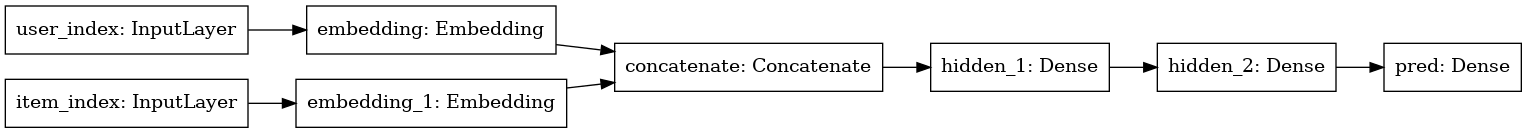

In [19]:
tf.keras.utils.plot_model(model, rankdir="LR")

We define the optimizer (Adam) and loss (mean squared error). We'll also add RMSE as a metric to compare to our Lab 1 Results.

In [20]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")],
)

All the pieces are together. It's time to train our model! Run the cell below to kick off training.

TensorFlow will automatically detect our GPU, but if we want to manually specify it, we can with [tf.device](https://www.tensorflow.org/api_docs/python/tf/device).

One small difference is, that `KerasSequenceLoader` requires to add the validation data as a callback with `KerasSequenceValidater`.

In [21]:
from nvtabular.loader.tensorflow import KerasSequenceValidater

with tf.device("/gpu:0"):
    history = model.fit(train_ds, callbacks=[KerasSequenceValidater(valid_ds)], epochs=2)

Epoch 1/2
1462/1462 [==============================] - 66s 43ms/step - loss: 2.8612 - rmse: 1.5983
{'val_loss': 2.5240571, 'val_rmse': 1.2435752}
Epoch 2/2
1462/1462 [==============================] - 60s 41ms/step - loss: 0.9998 - rmse: 0.9998
{'val_loss': 2.16542, 'val_rmse': 1.0288724}


## 4. Wrap Up

Hmm, we have a validation RMSE of about `1.15`. That's already better than our ALS result of about `1.20`! Can we do better? We sure can! Run the code below to shut down the kernel before moving on to the next notebook.

In [22]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="./images/DLI_Header.png"></a></div>